# Creating Raster Images

In this step the vector outlines of the areas with and without mountain biking will be used to mask out raster images of elevation values

# Setup

In [1]:
import pickle

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import rasterio
import rasterio.mask

# File path for project data
FILE_PATH = "G:/UNCG_Capstone/"
# File path for NC counties
NC_COUNTIES = FILE_PATH + "NC_counties/North_Carolina_State_and_County_Boundary_Polygons.shp"
# Raster Images of County Elevation
ELEV_PATH = FILE_PATH + "Elevation_Data/"
# Input
INPUT = FILE_PATH + "Output/Cleaned_Data/"
# Output
OUTPUT = FILE_PATH + "Output/Raster_Pickles/"

# NC Map Fig size
NC_MAP_SIZE = (15,10)
# Size for a single plot
PLOT_1 = (10, 7)
# Sizes for others plots
PX = 7
PY = 5
# Park Color
PARK_COLOR = 'mediumseagreen'

## Functions

In [2]:
def pickle_park_rasters(df, county, dem_location = ELEV_PATH, output_path = OUTPUT, geo_col = 4, land_use_col = -1, id_col = 1):
    """For all shapes located in a county mask out elevation then pickle the resulting numpy array.
    Elevation rasters are named [COUNTY]_[ID].pickle. The id value can be used to remap elevation
    rasters to dataframes to retrieve other information. The trail_row-[ID NUMBER] can also be used 
    to reference the original OpenStreetMap geometries.
    
    ## Parameters
    - df: GeoDataframe to pull shapes from
    - county: NC county to reference. lower case, spaces replaced with '_'
    - dem_location: file path to pull dem data from
    - geo_col: index of df geometry column + 1
    - land_use_col: index of land_use
    - id_col: index of df id column + 1"""
    elev = rasterio.open(f"zip://{dem_location}/{county}.zip!{county}.asc", 'r')

    for row in df.itertuples():
        # Get a mask
        land_contours, _ = rasterio.mask.mask(elev, [row[geo_col]], crop = True, filled = True, indexes = 1)
        with open(f"{output_path}{row[land_use_col]}/{county}_{row[id_col]}.pickle", 'wb') as raster_pickle:
            pickle.dump(land_contours, raster_pickle)

## Data

In [3]:
trails = gpd.read_file(INPUT + "trails.shp", engine = "pyogrio")
parks = gpd.read_file(INPUT + "parks.shp", engine = "pyogrio")
nc = gpd.read_file(NC_COUNTIES, engine = "pyogrio")

In [4]:
trails.head()

,area,trail_row,geometry
0,6.739168e+05,0,"POLYGON ((573816.873 491670.935, 573807.105 49..."
1,3.175570e+06,1,"POLYGON ((827189.766 503455.791, 827179.954 50..."
2,4.483349e+05,2,"POLYGON ((804142.197 533906.373, 802699.519 53..."
3,2.175227e+06,3,"POLYGON ((502163.436 541197.184, 502153.625 54..."
4,3.743272e+05,4,"POLYGON ((874128.357 564348.367, 874118.580 56..."


In [5]:
parks.head()

,MA_ID,MA_NAME,OWNER,OWNER_TYPE,CATEGORY,Shape_Area,County,park_row,geometry
0,6726,Conservation Reserve Enhancement Program Easement,"NC Department of Agriculture, Division of Soil...",State,Easement,43422.652300,Halifax,3919,"POLYGON ((2449610.518 890227.747, 2449812.880 ..."
1,13849,Triangle Land Conservancy Easement,Triangle Land Conservancy,Private,Easement,244317.942081,Orange,2971,"POLYGON ((1971143.299 822961.576, 1971143.824 ..."
2,5589,City of Greensboro - OHenry Oaks Park,City of Greensboro,Local Government,Fee,44417.452780,Guilford,9723,"MULTIPOLYGON (((1772255.508 861472.883, 177219..."
3,23315,Three Rivers Land Trust Easement,Three Rivers Land Trust,Private,Easement,790412.216182,Rowan,2633,"POLYGON ((1505885.175 700247.058, 1505999.479 ..."
4,8038,Conservation Reserve Enhancement Program Easement,"NC Department of Agriculture, Division of Soil...",State,Easement,97698.825963,Hertford,4207,"POLYGON ((2578894.544 928521.896, 2578942.937 ..."


In [6]:
# Confirming there is a consistent CRS
print(f"Trail CRS: {trails.crs}, Parks CRS: {parks.crs}")

Trail CRS: EPSG:6543, Parks CRS: EPSG:6543


# Checking MTB Trail Areas That Cross Multiple Counties

In [7]:
join = gpd.sjoin(left_df = trails[["trail_row", "area", "geometry"]], right_df = nc[["geometry", "County"]], how = 'left', predicate = 'intersects')
(join["trail_row"]
    .value_counts()
    .sort_values(ascending = False)
    .head(20))

trail_row
22    2
64    2
13    2
86    2
58    2
38    2
49    2
2     2
23    2
7     1
10    1
9     1
8     1
4     1
6     1
5     1
12    1
11    1
18    1
14    1
Name: count, dtype: int64

There are several trail systems that intersect with more than one county.

In [8]:
mask = (join["trail_row"]
    .value_counts() > 1)

# Index of values where true
mask = mask[mask.values]

multi_county = join.set_index('trail_row').loc[mask.index, :]
multi_county.head()

,area,geometry,index_right,County
trail_row,,,,
22,1.230202e+07,"POLYGON ((892972.614 615061.358, 892962.823 61...",42,Transylvania
22,1.230202e+07,"POLYGON ((892972.614 615061.358, 892962.823 61...",51,Henderson
23,2.446455e+07,"POLYGON ((912753.426 622813.044, 912743.612 62...",42,Transylvania
23,2.446455e+07,"POLYGON ((912753.426 622813.044, 912743.612 62...",51,Henderson
64,1.046252e+06,"POLYGON ((1461533.084 911293.580, 1461523.297 ...",85,Yadkin


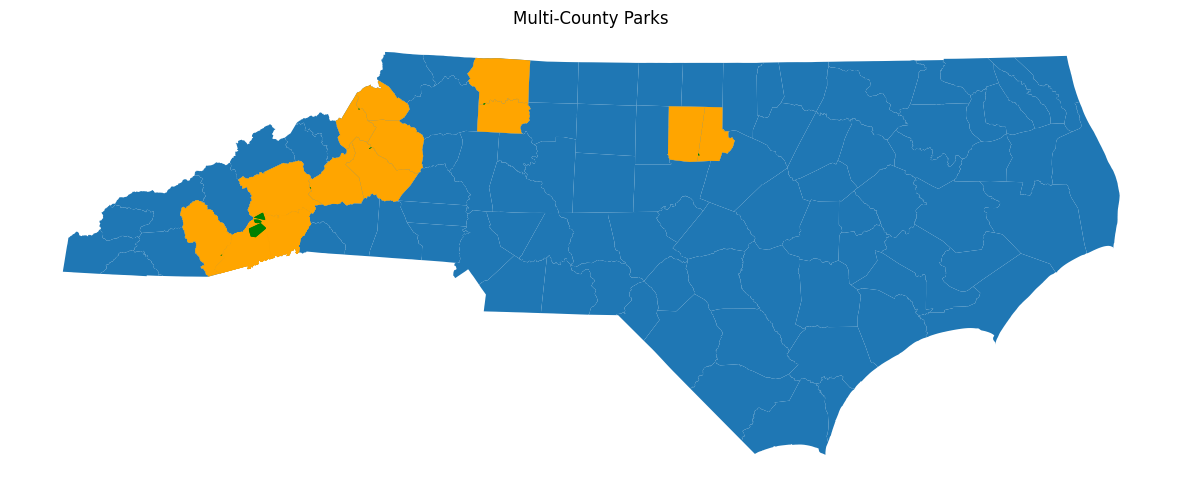

In [9]:
fig, ax = plt.subplots(figsize = NC_MAP_SIZE)

nc.plot(ax = ax)

for _, county in enumerate(multi_county.County.values):
    nc.loc[nc.County == county].plot(ax = ax, color = 'orange')

multi_county.plot(ax = ax, color = 'green')

ax.set_title("Multi-County Parks")
plt.axis('off');

The area that exists in each county will be investigated.

In [10]:
# dict to build data frame, trail_row is going to be used as the common key
size_compare = {"trail_row" : [], "smaller_county" : [], "larger_county" : [], "ratio" : []}

# For each trail get the counties it lies in
for _, trail in enumerate(multi_county.index.unique()):
    
    df = multi_county.loc[trail,:].reset_index()

    # c0 = df.loc[0,["County", "geometry"]]
    # c1 = df.loc[1,["County", "geometry"]]

    # Get area that is in each county
    c0_diff = df.loc[0,"geometry"].intersection(nc.loc[nc.County == df.loc[0, "County"], "geometry"])
    c1_diff = df.loc[1,"geometry"].intersection(nc.loc[nc.County == df.loc[1, "County"], "geometry"])

    # Find what ratio of the whole the smaller part makes up
    smaller_percent = np.min((c0_diff.values[0].area, 
                              c1_diff.values[0].area)) / df.loc[0,"geometry"].area
    
    # add values back to dataframe
    df["diff"] = [c0_diff.values[0].area, c1_diff.values[0].area]

    size_compare["trail_row"].append(trail)
    size_compare["ratio"].append(smaller_percent)
    size_compare["smaller_county"].append(df.sort_values(by = "diff").loc[0,"County"])
    size_compare["larger_county"].append(df.loc[1, "County"])

size_df = pd.DataFrame(size_compare)
size_df = size_df.merge(trails[["trail_row", "area"]])
size_df.assign(smaller_area = size_df.ratio * size_df.area).sort_values(by = "smaller_area")

,trail_row,smaller_county,larger_county,ratio,area,smaller_area
8,2,Transylvania,Jackson,0.004574,4.483349e+05,2.050890e+03
1,23,Transylvania,Henderson,0.000277,2.446455e+07,6.768562e+03
2,64,Yadkin,Surry,0.018744,1.046252e+06,1.961112e+04
5,58,Burke,Caldwell,0.062073,9.933288e+05,6.165924e+04
6,38,Buncombe,McDowell,0.170142,5.140576e+05,8.746254e+04
4,86,Durham,Orange,0.094339,1.033434e+06,9.749346e+04
7,49,Avery,Watauga,0.237921,5.655134e+05,1.345473e+05
0,22,Transylvania,Henderson,0.402354,1.230202e+07,4.949764e+06
3,13,Transylvania,Henderson,0.136806,8.333155e+07,1.140028e+07


In [11]:
parks.Shape_Area.describe()

count    3.000000e+02
mean     1.087756e+06
std      8.067636e+06
min      3.788145e+03
25%      4.684330e+04
50%      1.231104e+05
75%      4.446850e+05
max      1.305064e+08
Name: Shape_Area, dtype: float64

Of all the trails that span 2 counties only `trail_row` 2 has a smaller area that has less area than the smallest non MTB area. That section will be removed.

In [12]:
join = join.set_index(["trail_row", "County"]).drop(index = (2, "Transylvania")).reset_index()

# Merge Data Sets

In [13]:
# Create a formal trail id that is easily split
join["id"] = join["trail_row"].apply(lambda x: f"trail_row-{x}")
join["land_use"] = "MTB"
join.head(2)

,trail_row,County,area,geometry,index_right,id,land_use
0,0,Clay,6.739168e+05,"POLYGON ((573816.873 491670.935, 573807.105 49...",50,trail_row-0,MTB
1,1,Transylvania,3.175570e+06,"POLYGON ((827189.766 503455.791, 827179.954 50...",42,trail_row-1,MTB


In [14]:
parks_join = parks[["MA_ID", "Shape_Area", "County", "geometry"]].copy()
parks_join["MA_ID"] = parks_join.MA_ID.apply(lambda x: f"MA_ID-{x}")
parks_join.rename(columns = {"MA_ID" : "id", "Shape_Area" : "area"}, inplace = True)
parks_join["land_use"] = "No MTB"
parks_join.head(2)

,id,area,County,geometry,land_use
0,MA_ID-6726,43422.652300,Halifax,"POLYGON ((2449610.518 890227.747, 2449812.880 ...",No MTB
1,MA_ID-13849,244317.942081,Orange,"POLYGON ((1971143.299 822961.576, 1971143.824 ...",No MTB


In [15]:
trails_parks = pd.concat([join[["id", "County", "area", "geometry", "land_use"]],
           parks_join.rename( columns = {"ParkID" : "id", "Shape_Area" : "area"} ) ],
           join = 'inner')

trails_parks.head()

,id,County,area,geometry,land_use
0,trail_row-0,Clay,6.739168e+05,"POLYGON ((573816.873 491670.935, 573807.105 49...",MTB
1,trail_row-1,Transylvania,3.175570e+06,"POLYGON ((827189.766 503455.791, 827179.954 50...",MTB
2,trail_row-2,Jackson,4.483349e+05,"POLYGON ((804142.197 533906.373, 802699.519 53...",MTB
3,trail_row-3,Cherokee,2.175227e+06,"POLYGON ((502163.436 541197.184, 502153.625 54...",MTB
4,trail_row-4,Transylvania,3.743272e+05,"POLYGON ((874128.357 564348.367, 874118.580 56...",MTB


Export the merged data set

In [16]:
trails_parks.to_file(INPUT + "trails_parks_merged.shp")

# Mask Out Raster Values

In [20]:
counties = trails_parks.County.unique()
for i,county in enumerate(counties):
    print(f"Exporting {county.lower()} county...")
    pickle_park_rasters(df = trails_parks.loc[trails_parks.County == county,:],
                    county = county.lower().replace(" ", "_")) # make sure underscore for new hanover

Exporting clay county...
Exporting transylvania county...
Exporting jackson county...
Exporting cherokee county...
Exporting haywood county...
Exporting henderson county...
Exporting graham county...
Exporting swain county...
Exporting buncombe county...
Exporting rutherford county...
Exporting mcdowell county...
Exporting burke county...
Exporting avery county...
Exporting watauga county...
Exporting mecklenburg county...
Exporting caldwell county...
Exporting yadkin county...
Exporting surry county...
Exporting cabarrus county...
Exporting orange county...
Exporting guilford county...
Exporting stokes county...
Exporting chatham county...
Exporting cumberland county...
Exporting wake county...
Exporting durham county...
Exporting halifax county...
Exporting rowan county...
Exporting hertford county...
Exporting forsyth county...
Exporting new hanover county...
Exporting pitt county...
Exporting hoke county...
Exporting lincoln county...
Exporting lenoir county...
Exporting alleghany 